<a href="https://colab.research.google.com/github/michalinahulak/alien_vs_predator_CV/blob/main/alien_vs_predator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project
The goal of this project is to build a model that can classify images of Aliens and Predators. This is a classic image classification problem, and we will use deep learning techniques to tackle it. We will use a dataset of images of Aliens and Predators, which will be split into a training and testing set. We will preprocess the images and apply data augmentation to increase the size of our training set. We will then build a convolutional neural network (CNN) to classify the images. We will evaluate our model on the testing set and use metrics such as accuracy, precision, recall, and F1-score to measure its performance.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

import os

from keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!ls -la '/content/drive/My Drive/Colab Notebooks/Codecool/alien vs predator'

total 108431
-rw------- 1 root root 14823464 Apr 30 19:07 alien_predator.zip
-rw------- 1 root root  1465114 May 11 19:32 alien_vs_predator
drwx------ 2 root root     4096 Apr 30 20:25 alien_vs_predator_thumbnails
drwx------ 4 root root     4096 Apr 30 20:25 data
-rw------- 1 root root 94735120 May 11 19:22 predator_alien_model.h5


In [4]:
%cd /content/drive/My Drive/Colab Notebooks/Codecool/alien vs predator

/content/drive/My Drive/Colab Notebooks/Codecool/alien vs predator


# Functions

In [5]:
def plot_class_distribution(dataset_path, dataset_name):
    class_names = sorted(os.listdir(dataset_path))
    n_classes = len(class_names)
    class_dis = [len(os.listdir(dataset_path + '/' + name)) for name in class_names]
    fig = px.pie(names=class_names, 
                 values=class_dis, 
                 hole=0.3, 
                 color_discrete_sequence=["#1D3B2F", "#47077F"])
    fig.update_layout(title={'text': f"Class distribution in {dataset_name}", 'x':0.48},
                      width=500,
                      height=500)
    fig.show()

In [6]:
def display_random_images(dataset):
    plt.figure(figsize=(5, 5))
    for images, labels in dataset.take(1):
        for i in range(4):
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.show()

In [7]:
def apply_noise(image):
    image = tf.cast(image, tf.float32) / 255.0
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    noisy_image = image + noise
    noisy_image = tf.clip_by_value(noisy_image, clip_value_min=0.0, clip_value_max=1.0)
    noisy_image = tf.cast(noisy_image * 255, tf.uint8)
    return noisy_image

In [8]:
def flip_image(image):
    flip = tf.random.uniform([], 0, 3, dtype=tf.int32)
    if flip == 0:
        return image
    elif flip == 1:
        return tf.image.flip_left_right(image)
    else:
        return tf.image.flip_up_down(image)

# Upload data

In [5]:
path_train = '/content/drive/MyDrive/Colab Notebooks/Codecool/alien vs predator/data/train'
path_val = '/content/drive/MyDrive/Colab Notebooks/Codecool/alien vs predator/data/validation'

In [6]:
batch_size = 6
img_height = 224
img_width = 224

In [7]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                                  rotation_range=10,
                                  width_shift_range=0.1,
                                 height_shift_range=0.1,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                   validation_split=0.2)

train_ds = train_datagen.flow_from_directory(directory=path_train,
                                             target_size=(img_height, img_width),
                                             batch_size=batch_size,
                                             class_mode='categorical',
                                             shuffle=True,
                                             subset = 'training')

val_ds = train_datagen.flow_from_directory(path_train,
                                                    target_size = (img_height, img_width),
                                                    batch_size = batch_size, 
                                                    shuffle = False, 
                                                    class_mode = 'categorical',
                                                   subset = 'validation')

test_ds = train_datagen.flow_from_directory(directory=path_val,
                                           target_size=(img_height, img_width),
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=True)

Found 556 images belonging to 2 classes.
Found 138 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [10]:
ds_train = image_dataset_from_directory(
    path_train,
    labels='inferred',
    shuffle=True,
    image_size=(img_height, img_width), 
    seed= 123
)

Found 694 files belonging to 2 classes.


In [32]:
ds_val = image_dataset_from_directory(
    path_val,
    labels='inferred',
    shuffle=True,
    image_size=(img_height, img_width),
    seed=123
)

Found 200 files belonging to 2 classes.


# EDA

In [8]:
class_names = ds_train.class_names

NameError: ignored

In [ ]:
plot_class_distribution(path_train, "ds_train")

In [ ]:
plot_class_distribution(path_val, "ds_val")

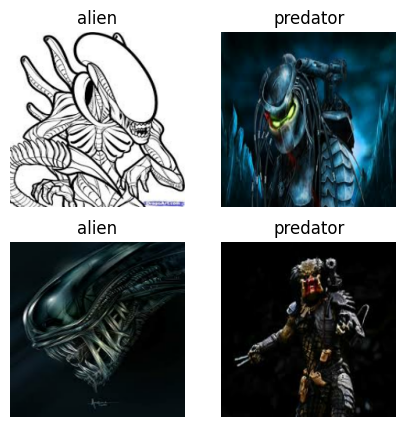

In [34]:
display_random_images(dataset= ds_train)

## RandomContrast

In [15]:
ds_train_augmented_contrast = ds_train.map(lambda x, y: (preprocessing.RandomContrast(0.5)(tf.image.rgb_to_grayscale(x)), y))

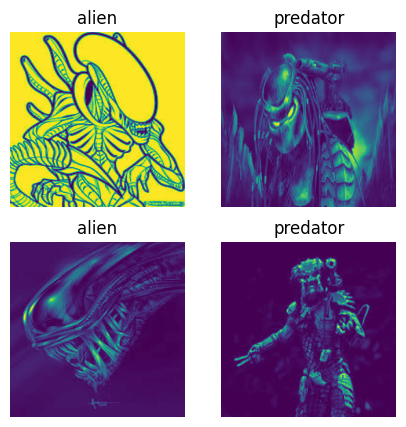

In [ ]:
display_random_images(ds_train_augmented_contrast)

## Grayscale

In [ ]:
ds_train_augmented_gray_rgb = ds_train_augmented_contrast.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))

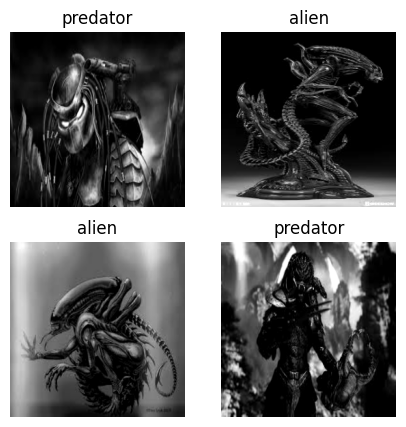

In [ ]:
display_random_images(ds_train_augmented_gray_rgb)

## With noise

In [ ]:
ds_train_noisy = ds_train.map(lambda x, y: (apply_noise(x), y))

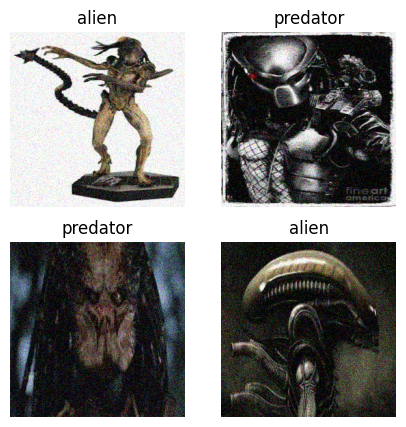

In [ ]:
display_random_images(ds_train_noisy)

## random flip

In [ ]:
ds_train_flipped = ds_train.map(lambda x, y: (flip_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)

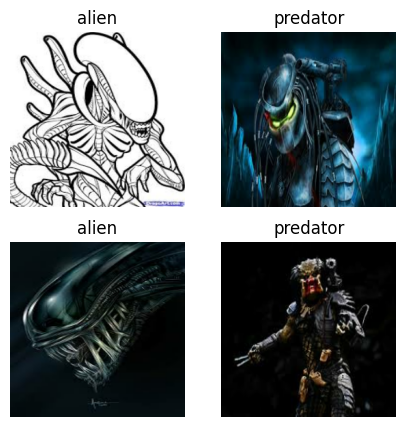

In [ ]:
display_random_images(ds_train_flipped)

# Models

In [11]:
num_classes = len(ds_train.class_names)
input_shape = (img_height, img_width, 3)

## Convolution neural networks

In [25]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),  
  RandomRotation(0.2), 
  RandomZoom(0.2),  
])

In [26]:
model1 = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, 
                                                       input_shape=input_shape),
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [27]:
model2 = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, 
                                                       input_shape=input_shape),
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [28]:
model3 = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, 
                                                       input_shape=input_shape),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [29]:
model4 = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, 
                                                       input_shape=input_shape),
  data_augmentation,
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(256, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [37]:
models = [model1, model2, model3, model4]
histories = []
results = []
early_stopping_monitor = EarlyStopping(patience=2)

for i, model in enumerate(models):
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy', 'sparse_categorical_crossentropy'])
    
    history = model.fit(ds_train, epochs=50, callbacks=[early_stopping_monitor], validation_data=ds_val)
    result_val = model.evaluate(ds_val, verbose=0)
    histories.append(history)
    
    result_train = model.evaluate(ds_train, verbose=0)
    
    results.append({'Model_name': f'Model{i+1}',
                     'train_acc': result_train[1], 
                    'train_loss': result_train[0],
                     'val_acc': result_val[1], 
                    'val_loss': result_val[0],
                     })

df_results = pd.DataFrame(results)


Epoch 1/50
22/22 [==============================] - 6s 96ms/step - loss: 0.5967 - accuracy: 0.6888 - sparse_categorical_crossentropy: 0.5967 - val_loss: 0.5638 - val_accuracy: 0.6900 - val_sparse_categorical_crossentropy: 0.5638
Epoch 2/50
22/22 [==============================] - 2s 85ms/step - loss: 0.5166 - accuracy: 0.7478 - sparse_categorical_crossentropy: 0.5166 - val_loss: 0.5234 - val_accuracy: 0.7450 - val_sparse_categorical_crossentropy: 0.5234
Epoch 3/50
22/22 [==============================] - 2s 84ms/step - loss: 0.5153 - accuracy: 0.7594 - sparse_categorical_crossentropy: 0.5153 - val_loss: 0.5209 - val_accuracy: 0.7400 - val_sparse_categorical_crossentropy: 0.5209
Epoch 4/50
22/22 [==============================] - 2s 85ms/step - loss: 0.4896 - accuracy: 0.7709 - sparse_categorical_crossentropy: 0.4896 - val_loss: 0.6678 - val_accuracy: 0.6450 - val_sparse_categorical_crossentropy: 0.6678
Epoch 5/50
22/22 [==============================] - 3s 96ms/step - loss: 0.5241 - ac

In [38]:
df_results

,Model_name,train_acc,train_loss,val_acc,val_loss
0,Model1,0.756484,0.487463,0.680,0.554909
1,Model2,0.721902,0.543895,0.660,0.672336
2,Model3,0.995677,0.024316,0.760,1.342387
3,Model4,0.753602,0.498930,0.725,0.579275


## Resnet50

In [12]:
early_stopping_monitor = EarlyStopping(patience=2)
input_shape = (img_height, img_width, 3)
num_classes = 2

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stopping_monitor])

train_loss, train_acc = model.evaluate(train_ds)
val_loss, val_acc = model.evaluate(val_ds)
test_loss, test_acc = model.evaluate(test_ds)
results = []
results.append({  'train_acc': train_acc, 
                    'train_loss': train_loss,
                     'val_acc': val_acc, 
                    'val_loss': val_loss,
                    'test_acc': test_acc, 
                    'test_loss': test_loss,
                     })
results_resnet = pd.DataFrame(results)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/50
93/93 [==============================] - 18s 134ms/step - loss: 0.3942 - accuracy: 0.8219 - val_loss: 0.2224 - val_accuracy: 0.9348
Epoch 2/50
93/93 [==============================] - 11s 118ms/step - loss: 0.1322 - accuracy: 0

In [13]:
results_resnet

,train_acc,train_loss,val_acc,val_loss,test_acc,test_loss
0,0.991007,0.034739,0.934783,0.14888,0.905,0.226502


In [41]:
model.save('predator_alien_model.h5')